In [2]:
import pandas as pd
import numpy as np
import requests
import csv
import matplotlib.pyplot as plt
import pickle
from statistics import mean, stdev
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [21]:
# import qrcode
# import qrcode.image.svg

# img = qrcode.make('https://docs.google.com/presentation/d/1z-kF9Rltb_fMu3Srgpz53xu5_4isePvYURqpCnwUwqk/edit?usp=sharing', image_factory=qrcode.image.svg.SvgImage)

# with open('qr.png', 'wb') as qr:
#     img.save(qr)


import requests

WIDTH = 400
HEIGHT = 400

DATA = "https://docs.google.com/presentation/d/1z-kF9Rltb_fMu3Srgpz53xu5_4isePvYURqpCnwUwqk/edit?usp=sharing"

image = requests.get(f"https://chart.googleapis.com/chart?chs={WIDTH}x{HEIGHT}&cht=qr&chl={DATA}")
image.raise_for_status()

with open("qr.png", "wb") as qr:
    qr.write(image.content)

In [9]:
docker_pred = {}
for i in range(1,11):
    for j in range(0,646):
#         if j >= 573 and j <= 599: continue
        f = open('Fuzzy Python/fuzzy_python_results/%s_%s.pkl'%(i,j), 'rb')
#         print(i,j)
        temp = pickle.load(f)
        
        pkl_dict = {}
        for prot in temp:
            pkl_dict[prot] = {}
            for go_id in temp[prot]:
                if temp[prot][go_id] >= 0.3:
                    pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])
  
        for protein in pkl_dict.keys():
            if i == 1:
                docker_pred[protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred[protein][go_id] = np.array([pkl_dict[protein][go_id]])
            else:

                for go_id in pkl_dict[protein]:
                    docker_pred[protein][go_id] = np.append(docker_pred[protein][go_id], pkl_dict[protein][go_id])

original_file = open('Verrou_tf/ieee_all2.pkl', 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]

In [10]:
# protein stats
stats = {}
dfs = {}
proteins = []
for name in list(docker_pred.keys()):
    proteins.append(name)
#     print(name, len(docker_pred[name]))
    stats[name] = {'GO term':[], 'Standard deviation':[], 'Mean': [], 'Standard error': [], 'Original Result': []}
    for i in docker_pred[name].keys():
        stats[name]['GO term'] = np.append(stats[name]['GO term'], i)
        stats[name]['Standard deviation'] = np.append(stats[name]['Standard deviation'], np.std(docker_pred[name][i].astype(np.float64), dtype=np.float64))
        stats[name]['Mean'] = np.append(stats[name]['Mean'], np.mean(docker_pred[name][i].astype(np.float64), dtype=np.float64))
        stats[name]['Standard error'] = np.append(stats[name]['Standard error'], (np.std(docker_pred[name][i].astype(np.float64), dtype=np.float64) / np.sqrt(len(docker_pred[name][i])).astype(np.float64)))
        if i in original_results[name].keys():
            stats[name]['Original Result'] = np.append(stats[name]['Original Result'], original_results[name][i])
        
    dfs[name] = pd.DataFrame(stats[name])

In [166]:
count = 0
sig_file = open('Verrou_tf/References/sig_proteins_float.txt')
protein_sig = {}
# temp = []
for row in sig_file:
    if 'NEW PROTEIN' in row:
        p_name = proteins[count]
        protein_sig[p_name] = {}
        count += 1
        continue
        
    if len(row.split(',')) == 1:
        name = row[:-2]

    else:
        if 'Relative' not in name and 'CNH' not in name:
            scores = row.split(',')[:-1]
#             temp.append(scores)
            protein_sig[p_name][name + ' Mean'] = np.mean(np.array(scores).astype(float))
            protein_sig[p_name][name + ' Standard Deviation'] = np.std(np.array(scores).astype(float))

            protein_sig[p_name][name + ' Scores'] = np.array(scores).astype(float)

protein_sig = pd.DataFrame(protein_sig).T

In [176]:
a = np.array(list(protein_sig['[General] Absolute  significant Scores']))


In [202]:
for i,j in zip(protein_sig.index, protein_sig['[General] Absolute  significant Scores']):
    if (j < 6).any(): 
        print(i)
        print(protein_sig.loc[i]['[General] Absolute  significant Scores'])

SC5A6_RAT
[6.6226599  6.6226599  6.32162991 6.9236899  6.02059991 6.9236899
 6.6226599  6.32162991 6.02059991 6.32162991 6.9236899  6.32162991
 6.32162991 6.32162991 6.9236899  6.32162991 6.32162991 6.32162991
 6.32162991 6.32162991 6.32162991 6.6226599  6.32162991 6.32162991
 6.32162991 6.32162991 6.32162991 6.32162991 6.32162991 5.71956992
 6.32162991 5.71956992 6.32162991 6.32162991 5.71956992]
ARK72_MOUSE
[6.9236899  6.9236899  6.9236899  6.9236899  6.9236899  6.9236899
 6.9236899  6.9236899  6.9236899  6.9236899  6.9236899  6.9236899
 6.9236899  6.9236899  6.6226599  6.9236899  6.9236899  6.9236899
 6.6226599  6.9236899  6.6226599  6.9236899  6.9236899  6.6226599
 6.9236899  6.9236899  6.6226599  6.6226599  6.9236899  6.9236899
 6.6226599  6.9236899  6.9236899  6.6226599  6.9236899  6.9236899
 6.9236899  6.6226599  6.9236899  6.9236899  6.9236899  6.6226599
 6.9236899  6.9236899  6.9236899  6.9236899  6.9236899  6.9236899
 6.9236899  6.9236899  6.9236899  6.9236899  6.9236899  6.9

In [182]:
temp = []
for i in a:
    for j in i:
        temp.append(j)


(array([4.54000e+02, 2.23000e+02, 8.10000e+01, 1.60000e+01, 7.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.59000e+02, 1.58512e+05]),
 array([0.30103   , 0.96329599, 1.62556198, 2.28782797, 2.95009396,
        3.61235995, 4.27462594, 4.93689193, 5.59915792, 6.26142391,
        6.9236899 ]),
 <BarContainer object of 10 artists>)

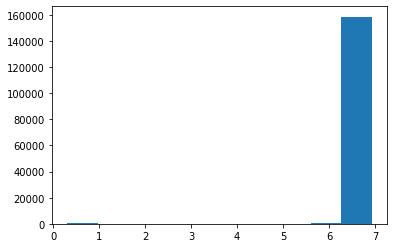

In [184]:
plt.hist(temp)


In [145]:
protein_sig_all = protein_sig

In [147]:
protein_sig_tf = protein_sig

In [153]:
protein_sig_py = protein_sig

In [8]:
dfs_tf = dfs
protein_class_std_tf = []
for protein in dfs.values():
    for value in protein['Standard deviation']:
        protein_class_std_tf.append(value)

In [11]:
dfs_py = dfs
protein_class_std_py = []
for protein in dfs_py.values():
    for value in protein['Standard deviation']:
        protein_class_std_py.append(value)

In [36]:
dfs_lib = dfs
protein_class_std_lib = []
for protein in dfs_lib.values():
    for value in protein['Standard deviation']:
        protein_class_std_lib.append(value)

In [5]:
dfs_all = dfs
protein_class_std_all = []
for protein in dfs_all.values():
    for value in protein['Standard deviation']:
        protein_class_std_all.append(value)

In [31]:
prot_std = {'Verificarlo Python': protein_class_std_py, 'Verrou All': protein_class_std_all, 'Verrou TF': protein_class_std_tf}

prot = pd.DataFrame(prot_std)

In [51]:
prot.to_pickle('stdev_graphs.pkl')

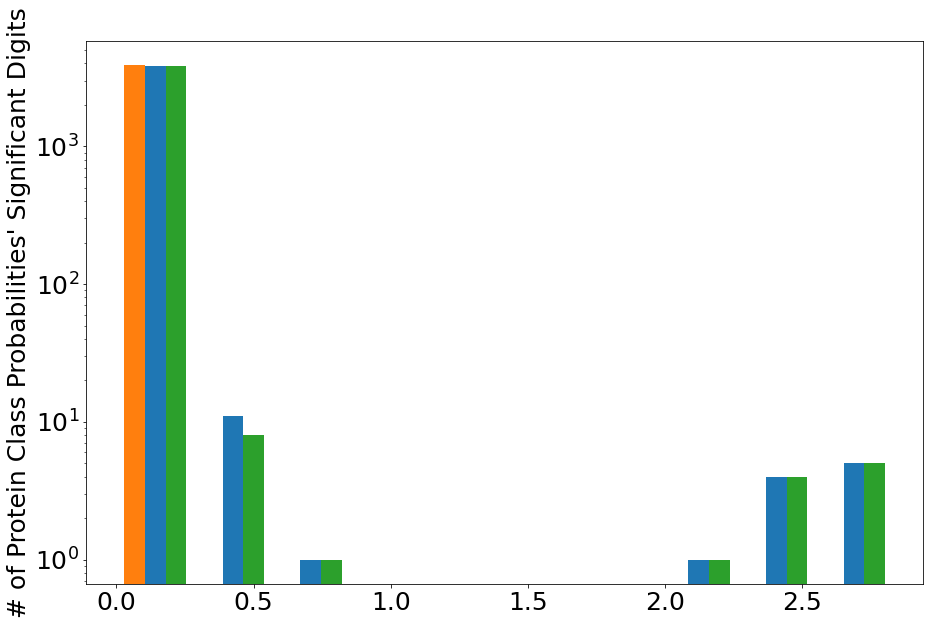

In [161]:
fig, ax = plt.subplots(figsize=(15,10))
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax.hist([list(protein_sig_py['[General] Absolute  significant Standard Deviation']), list(protein_sig_all['[General] Absolute  significant Standard Deviation']),list(protein_sig_tf['[General] Absolute  significant Standard Deviation'])], 10, histtype='bar', color=['tab:orange', 'tab:blue', 'tab:green'], label=['Verificarlo Python', 'Verrou All', 'Verrou TF'])
# ax.legend(prop={'size': 15})
# ax.set_xlabel('Standard Deviation', fontsize=15), 
ax.set_ylabel("# of Protein Class Probabilities' Significant Digits", fontsize=25)
ax.set_yscale('log')#, ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))
ax.tick_params(axis='both', which='major', labelsize=25);

plt.savefig('stdev_sigdig.pdf', bbox_inches ="tight")

/tmp/ipykernel_69896/3772704479.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Verrou All', 'Verrou TF', 'Verificarlo Python'], fontsize=25)


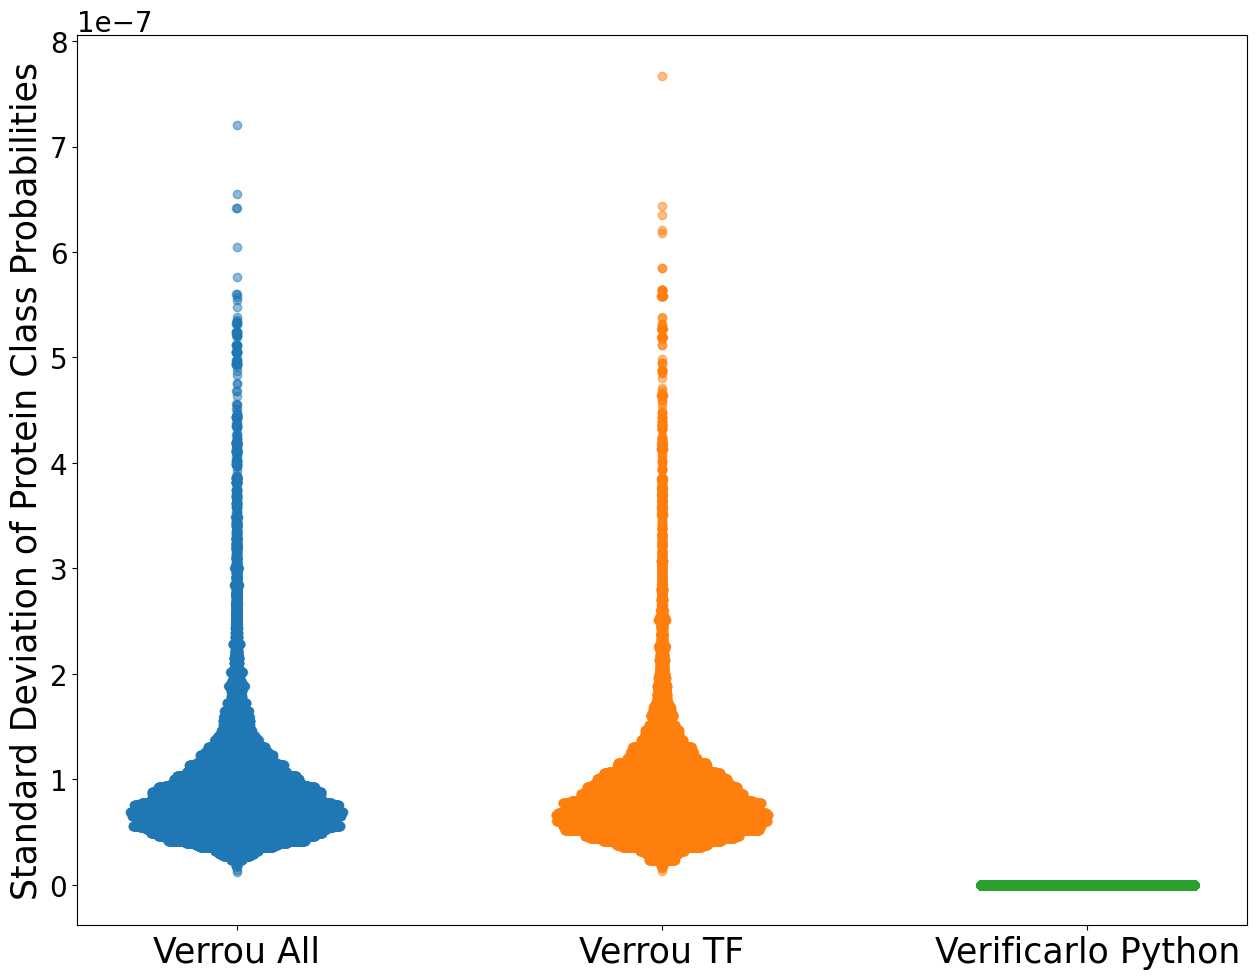

In [15]:
def simple_beeswarm(y, nbins=None):
    """
    Returns x coordinates for the points in ``y``, so that plotting ``x`` and
    ``y`` results in a bee swarm plot.
    """
    y = np.asarray(y)
    if nbins is None:
        nbins = len(y) // 6

    # Get upper bounds of bins
    x = np.zeros(len(y))
    ylo = np.min(y)
    yhi = np.max(y)
    dy = (yhi - ylo) / nbins
    ybins = np.linspace(ylo + dy, yhi - dy, nbins - 1)

    # Divide indices into bins
    i = np.arange(len(y))
    ibs = [0] * nbins
    ybs = [0] * nbins
    nmax = 0
    for j, ybin in enumerate(ybins):
        f = y <= ybin
        ibs[j], ybs[j] = i[f], y[f]
        nmax = max(nmax, len(ibs[j]))
        f = ~f
        i, y = i[f], y[f]
    ibs[-1], ybs[-1] = i, y
    nmax = max(nmax, len(ibs[-1]))

    # Assign x indices
    dx = 1 / (nmax // 2)
    for i, y in zip(ibs, ybs):
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(y)]
            a = i[j::2]
            b = i[j+1::2]
            x[a] = (0.5 + j / 3 + np.arange(len(b))) * dx
            x[b] = (0.5 + j / 3 + np.arange(len(b))) * -dx

    return x


prot = pd.read_pickle('/home/ines/Documents/Thesis/stdev_graphs.pkl')
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(0.2, 0.1, 0.98, 0.99)
ax = fig.add_subplot(1, 1, 1)
y = np.random.gamma(20000, 1090, 900)
x1 = simple_beeswarm(prot['Verrou All'])
# ax.plot(x, prot['Verrou All'], 'o', alpha=0.5)
x2 = simple_beeswarm(prot['Verrou TF']) + 4
x3 = simple_beeswarm(prot['Verificarlo Python']) + 8
ax.plot(np.array([x1, x2, x3]).T, prot[['Verrou All', 'Verrou TF', 'Verificarlo Python']], 'o', alpha=0.5)
plt.yticks(fontsize=20)
ax.set_xticklabels(['', 'Verrou All', 'Verrou TF', 'Verificarlo Python'], fontsize=25)
# ax.tick_params(axis ='x', which ='major',labelsize = 16, pad = 12)
# g.set_xticklabels(['# of Proteins'], fontsize=15), plt.ylabel('Standard Deviation', fontsize=15);
ax.set_ylabel('Standard Deviation of Protein Class Probabilities', fontsize=25);
ax.xaxis.set_major_locator(MultipleLocator(4))
text = ax.yaxis.get_offset_text()

# Set the size.
text.set_size(20)
plt.savefig('stdev_swarm.png', bbox_inches ="tight")


/tmp/ipykernel_69896/2350986495.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Verificarlo Python', 'Verrou All', 'Verrou TF'], fontsize=25)


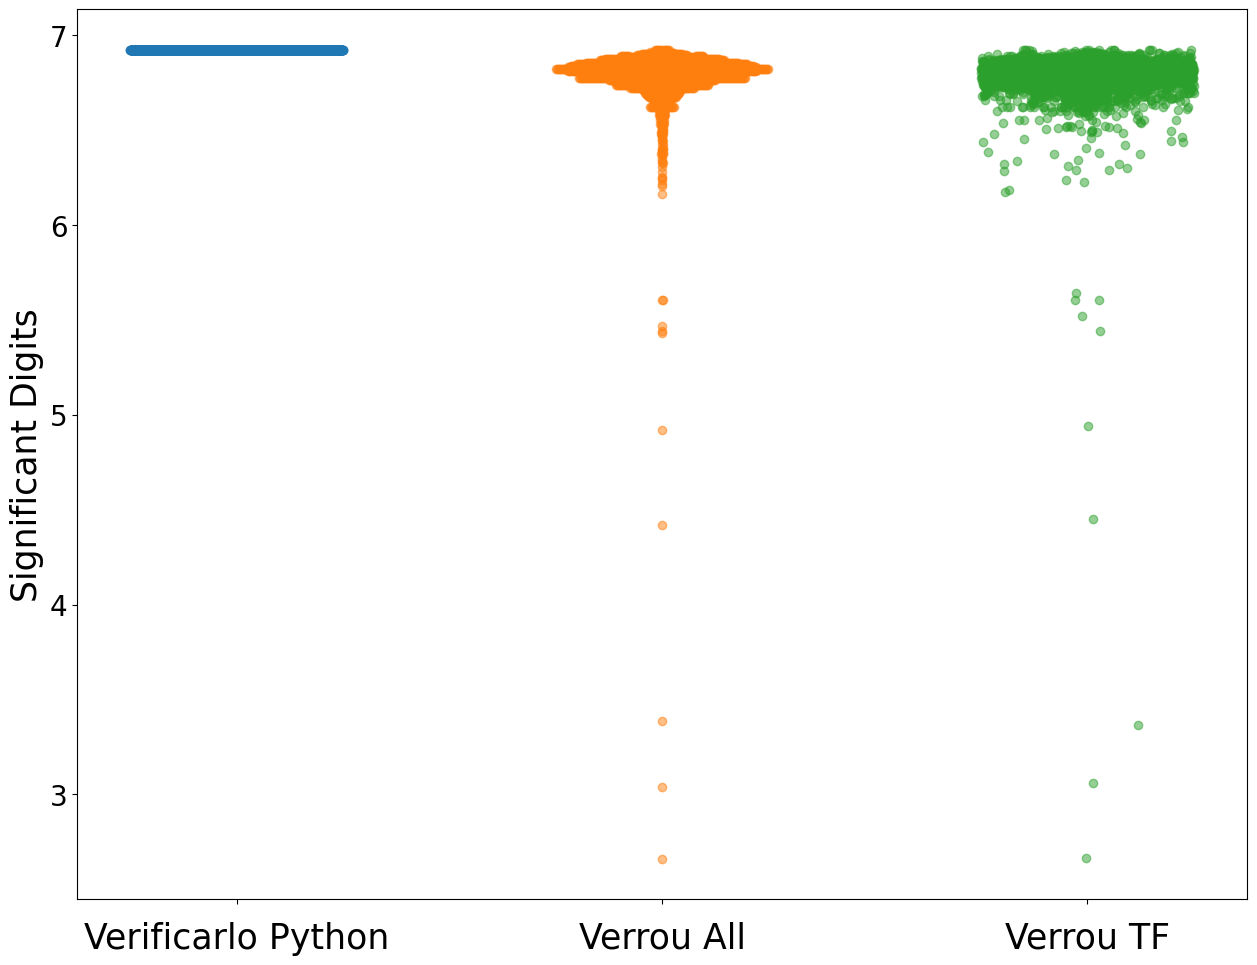

In [16]:
proteins = list(pickle.load(open('Verrou_corrected/ieee_all2.pkl', 'rb')).keys())
prot = {}

for i,j in zip(['Verificarlo Python', 'Verrou TF', 'Verrou All'],['Verrou_tf/References python/sig_proteins_float', 'Verrou_corrected/References/sig_proteins_tf', 'Verrou_corrected/References/sig_proteins_all']):
    
    count = 0
    sig_file = open('%s.txt'%j)
    protein_sig = {}

    for row in sig_file:
        if 'NEW PROTEIN' in row:
            p_name = sorted(proteins)[count]
            protein_sig[p_name] = None
            count += 1
            continue

        if len(row.split(',')) == 1:
            name = row[:-2]

        else:
#             if 'Relative' not in name and 'CNH' not in name:
            if '[General] Absolute  significant' in name:
                scores = row.split(',')[:-1]
#                 print(scores)
#                 print(np.mean(np.array(scores).astype(float)))
                protein_sig[p_name] = np.mean(np.array(scores).astype(float))
#                 protein_sig[p_name][name + ' Standard Deviation'] = np.std(np.array(scores).astype(float))
            
    prot[i] = list(protein_sig.values())
# protein_sig = pd.DataFrame(protein_sig).T 

prot = pd.DataFrame(prot)
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(0.2, 0.1, 0.98, 0.99)
ax = fig.add_subplot(1, 1, 1)
x1 = simple_beeswarm(prot['Verificarlo Python'])
# ax.plot(x, prot['Verrou All'], 'o', alpha=0.5)
x2 = simple_beeswarm(prot['Verrou TF']) + 4
x3 = simple_beeswarm(prot['Verificarlo Python']) + 8
ax.plot(np.array([x1, x2, x3]).T, prot[['Verificarlo Python', 'Verrou TF', 'Verrou All']], 'o', alpha=0.5);
ax.set_xticklabels(['', 'Verificarlo Python', 'Verrou All', 'Verrou TF'], fontsize=25)
ax.tick_params(axis ='x', which ='major',labelsize = 25, pad = 12)
# g.set_xticklabels(['# of Significant Digits'], fontsize=15), plt.ylabel('Standard Deviation', fontsize=15);
ax.set_ylabel('Significant Digits', fontsize=25);
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.yticks(fontsize=20)
# plt.show()
plt.savefig('sigdig_swarm.png', bbox_inches ="tight")


/tmp/ipykernel_769686/2605612148.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Verrou All', 'Verrou TF', 'Verificarlo Python'], fontsize=20)


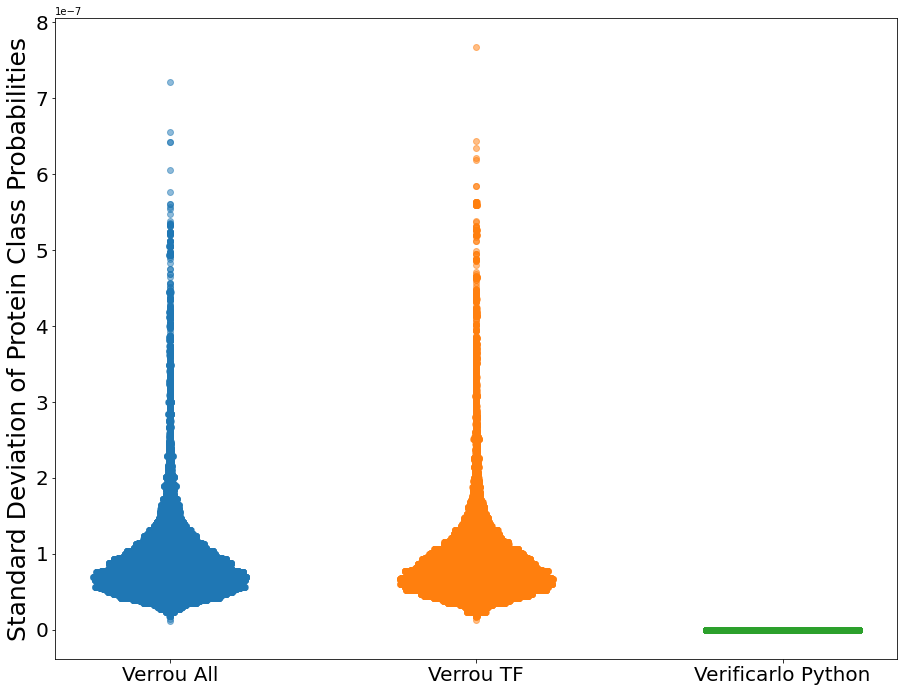

In [20]:
def simple_beeswarm(y, nbins=None):
    """
    Returns x coordinates for the points in ``y``, so that plotting ``x`` and
    ``y`` results in a bee swarm plot.
    """
    y = np.asarray(y)
    if nbins is None:
        nbins = len(y) // 6

    # Get upper bounds of bins
    x = np.zeros(len(y))
    ylo = np.min(y)
    yhi = np.max(y)
    dy = (yhi - ylo) / nbins
    ybins = np.linspace(ylo + dy, yhi - dy, nbins - 1)

    # Divide indices into bins
    i = np.arange(len(y))
    ibs = [0] * nbins
    ybs = [0] * nbins
    nmax = 0
    for j, ybin in enumerate(ybins):
        f = y <= ybin
        ibs[j], ybs[j] = i[f], y[f]
        nmax = max(nmax, len(ibs[j]))
        f = ~f
        i, y = i[f], y[f]
    ibs[-1], ybs[-1] = i, y
    nmax = max(nmax, len(ibs[-1]))

    # Assign x indices
    dx = 1 / (nmax // 2)
    for i, y in zip(ibs, ybs):
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(y)]
            a = i[j::2]
            b = i[j+1::2]
            x[a] = (0.5 + j / 3 + np.arange(len(b))) * dx
            x[b] = (0.5 + j / 3 + np.arange(len(b))) * -dx

    return x


prot = pd.read_pickle('/home/ines/Documents/Thesis/stdev_graphs.pkl')
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(0.2, 0.1, 0.98, 0.99)
ax = fig.add_subplot(1, 1, 1)
y = np.random.gamma(20000, 1090, 900)
x1 = simple_beeswarm(prot['Verrou All'])
# ax.plot(x, prot['Verrou All'], 'o', alpha=0.5)
x2 = simple_beeswarm(prot['Verrou TF']) + 4
x3 = simple_beeswarm(prot['Verificarlo Python']) + 8
ax.plot(np.array([x1, x2, x3]).T, prot[['Verrou All', 'Verrou TF', 'Verificarlo Python']], 'o', alpha=0.5)
plt.yticks(fontsize=20)
ax.set_xticklabels(['', 'Verrou All', 'Verrou TF', 'Verificarlo Python'], fontsize=20)
# ax.tick_params(axis ='x', which ='major',labelsize = 16, pad = 12)
# g.set_xticklabels(['# of Proteins'], fontsize=15), plt.ylabel('Standard Deviation', fontsize=15);
ax.set_ylabel('Standard Deviation of Protein Class Probabilities', fontsize=25);
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.savefig('stdev_swarm.png', bbox_inches ="tight")


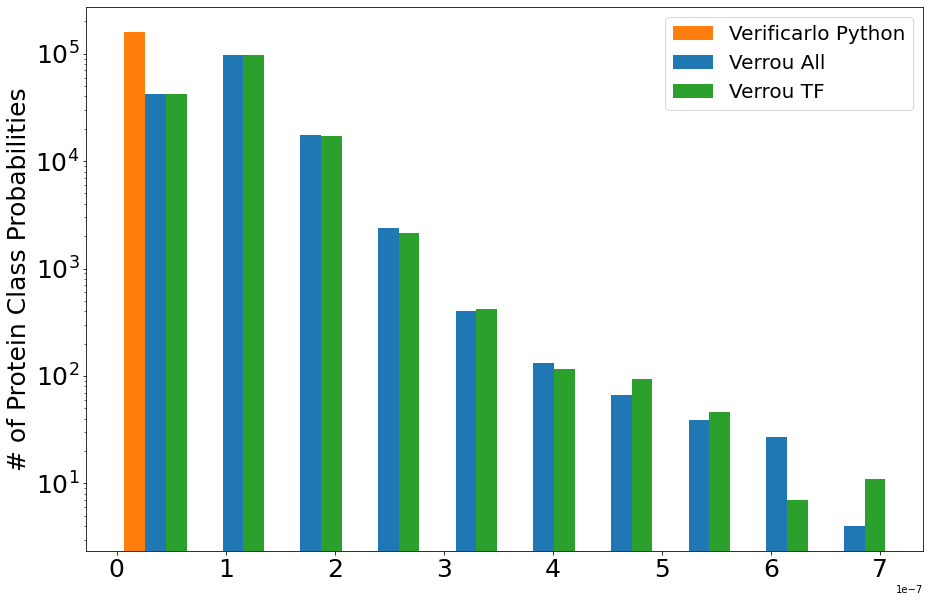

In [162]:
# plt.style.use(['dark_background', 'presentation'])
fig, ax = plt.subplots(figsize=(15,10))
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax.hist([protein_class_std_py, protein_class_std_all,protein_class_std_tf], 10, histtype='bar', color=['tab:orange', 'tab:blue', 'tab:green'], label=['Verificarlo Python', 'Verrou All', 'Verrou TF'])
ax.legend(prop={'size': 20})
# ax.set_xlabel('Standard Deviation', fontsize=15), 
ax.set_ylabel('# of Protein Class Probabilities', fontsize=25)
ax.set_yscale('log')#, ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))
ax.tick_params(axis='both', which='major', labelsize=25);

# ax.set_xticks(fontsize=15), ax.set_yticks(fontsize=15);

plt.savefig('stdev_hist.pdf', bbox_inches ="tight")

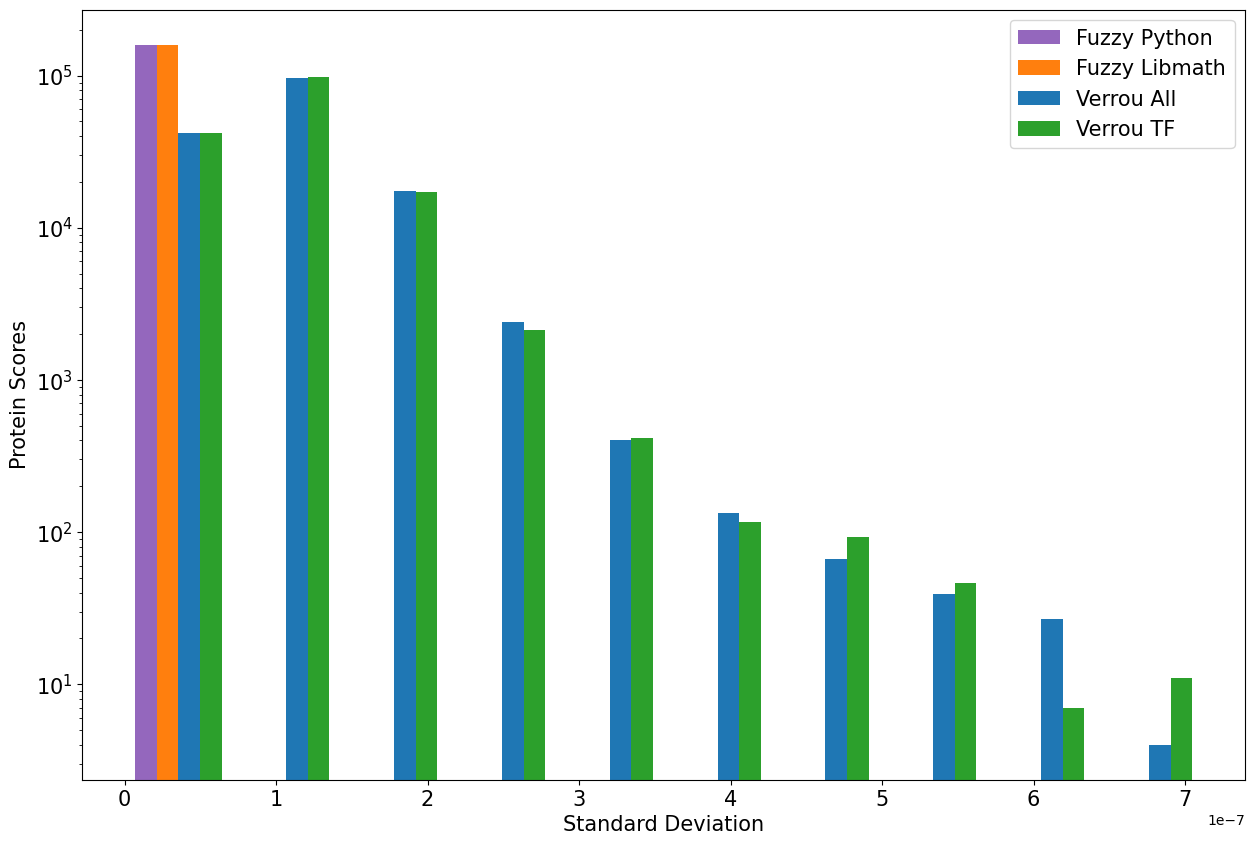

In [549]:
# plt.style.use(['dark_background', 'presentation'])
fig, ax = plt.subplots(figsize=(15,10))
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax.hist([protein_class_std_py, protein_class_std_lib, protein_class_std_all,protein_class_std_tf], 10, histtype='bar', color=['tab:purple', 'tab:orange', 'tab:blue', 'tab:green'], label=['Fuzzy Python', 'Fuzzy Libmath', 'Verrou All', 'Verrou TF'])
ax.legend(prop={'size': 15})
ax.set_xlabel('Standard Deviation', fontsize=15), ax.set_ylabel('# of Protein Class Probabilities', fontsize=15)
ax.set_yscale('log')#, ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))
ax.tick_params(axis='both', which='major', labelsize=15);

# ax.set_xticks(fontsize=15), ax.set_yticks(fontsize=15);

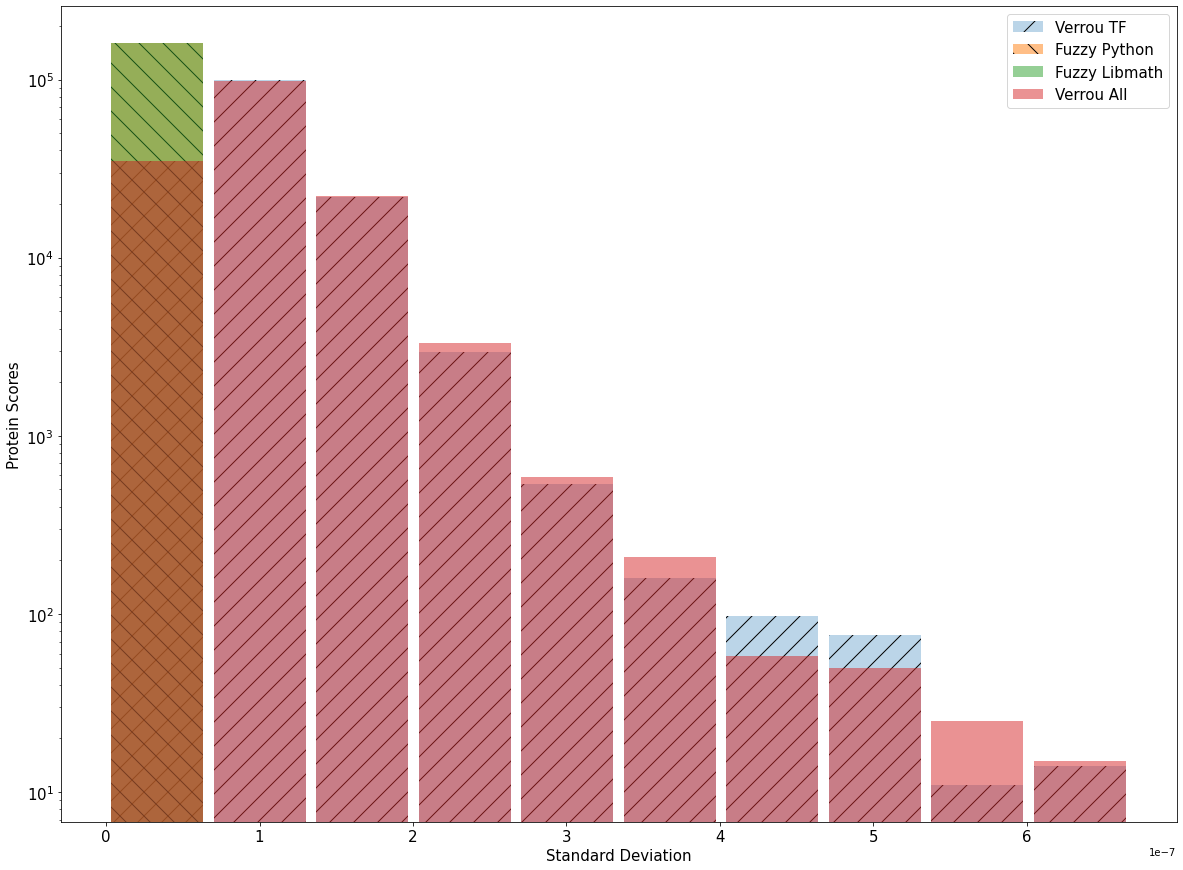

In [361]:
plt.figure(figsize=(20,15))
_, bins, bars = plt.hist(protein_class_std_tf, bins=10, alpha=0.3, hatch='/', rwidth = 0.9, label='Verrou TF')
# plt.bar_label(bars, fontsize=15)
_, _, bars = plt.hist(protein_class_std_py, bins=bins, alpha=0.5,hatch= '\\', rwidth = 0.9, label='Fuzzy Python')
# plt.bar_label(bars, fontsize=15)
_, _, bars = plt.hist(protein_class_std_lib, bins=bins, alpha=0.5,rwidth = 0.9, label='Fuzzy Libmath')
# plt.bar_label(bars, fontsize=15)
_, _, bars = plt.hist(protein_class_std_all, bins=bins, alpha=0.5, rwidth = 0.9, label='Verrou All')
# plt.bar_label(bars, fontsize=15)
plt.legend(fontsize=15)#, plt.title('Standard Deviation Across All Protein Classes', fontsize=20)
plt.xlabel('Standard Deviation', fontsize=15), plt.ylabel('Protein Scores', fontsize=15)
plt.yscale('log'), plt.xticks(fontsize=15), plt.yticks(fontsize=15);
#, plt.xlim(0,10e-8); 

## Protein Scores SigDig Graph

In [1]:
proteins = list(pickle.load(open('Verrou_corrected/ieee_all2.pkl', 'rb')).keys())
prot = {}

for i,j in zip(['Verificarlo Python', 'Verrou TF', 'Verrou All'],['Verrou_tf/References python/sig_proteins_float', 'Verrou_corrected/References/sig_proteins_tf', 'Verrou_corrected/References/sig_proteins_all']):
    
    count = 0
    sig_file = open('%s.txt'%j)
    protein_sig = {}

    for row in sig_file:
        if 'NEW PROTEIN' in row:
            p_name = sorted(proteins)[count]
            protein_sig[p_name] = None
            count += 1
            continue

        if len(row.split(',')) == 1:
            name = row[:-2]

        else:
#             if 'Relative' not in name and 'CNH' not in name:
            if '[General] Absolute  significant' in name:
                scores = row.split(',')[:-1]
#                 print(scores)
#                 print(np.mean(np.array(scores).astype(float)))
                protein_sig[p_name] = np.mean(np.array(scores).astype(float))
#                 protein_sig[p_name][name + ' Standard Deviation'] = np.std(np.array(scores).astype(float))
            
    prot[i] = list(protein_sig.values())
# protein_sig = pd.DataFrame(protein_sig).T 

NameError: name 'pickle' is not defined

In [23]:
mean(prot['Verrou All']), mean(prot['Verrou TF']), mean(prot['Verificarlo Python'])

(6.790122018496484, 6.789632451213453, 6.923689900271567)

/tmp/ipykernel_769686/2468394666.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Verificarlo Python', 'Verrou All', 'Verrou TF'], fontsize=20)


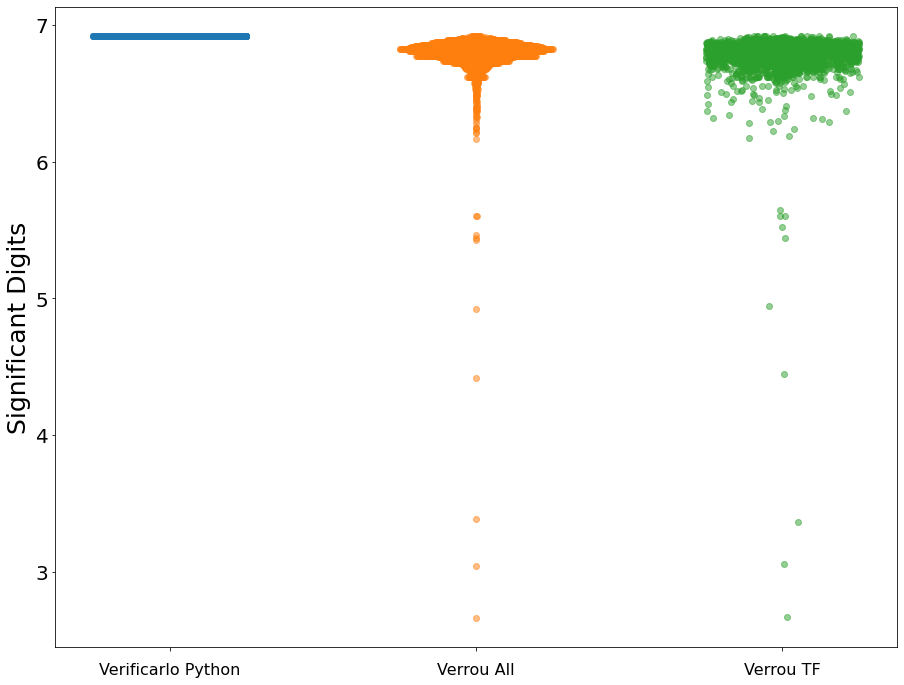

In [24]:
prot = pd.DataFrame(prot)
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(0.2, 0.1, 0.98, 0.99)
ax = fig.add_subplot(1, 1, 1)
x1 = simple_beeswarm(prot['Verificarlo Python'])
# ax.plot(x, prot['Verrou All'], 'o', alpha=0.5)
x2 = simple_beeswarm(prot['Verrou TF']) + 4
x3 = simple_beeswarm(prot['Verificarlo Python']) + 8
ax.plot(np.array([x1, x2, x3]).T, prot[['Verificarlo Python', 'Verrou TF', 'Verrou All']], 'o', alpha=0.5);
ax.set_xticklabels(['', 'Verificarlo Python', 'Verrou All', 'Verrou TF'], fontsize=20)
ax.tick_params(axis ='x', which ='major',labelsize = 16, pad = 12)
# g.set_xticklabels(['# of Significant Digits'], fontsize=15), plt.ylabel('Standard Deviation', fontsize=15);
ax.set_ylabel('Significant Digits', fontsize=25);
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.yticks(fontsize=20)
plt.savefig('sigdig_swarm.png', bbox_inches ="tight")


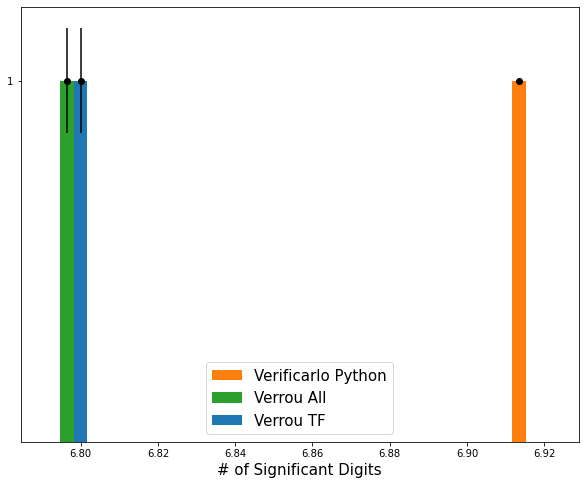

In [142]:
fig, ax = plt.subplots(figsize=(10,8))
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax.hist([[6.923690], [6.789670], [6.790739]], 10, histtype='bar', color=['tab:orange', 'tab:green', 'tab:blue'], label=['Verificarlo Python', 'Verrou All', 'Verrou TF'])
ax.errorbar([6.7965, 6.8, 6.9135], [1,1,1], yerr=[0.146341, 0.145973, 1.328037e-15], fmt="o", color="black")
plt.xlabel('# of Significant Digits', fontsize=15), plt.yticks([1],fontsize=10), plt.legend(fontsize=15);

plt.savefig('prot_sigdig.pdf', bbox_inches ="tight")

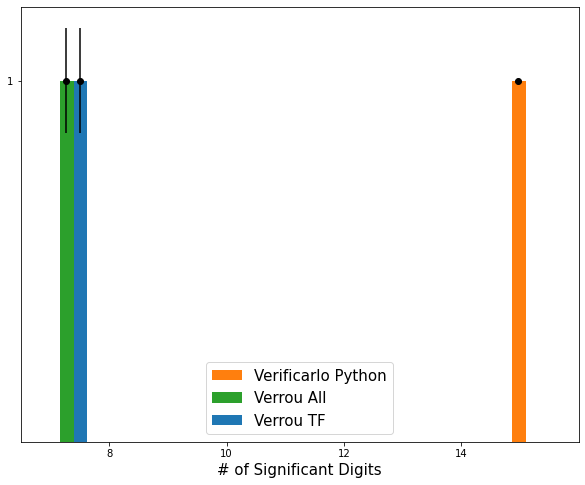

In [122]:
fig, ax = plt.subplots(figsize=(10,8))
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax.hist([[15.65356], [6.833369], [6.832138]], 10, histtype='bar', color=['tab:orange', 'tab:green', 'tab:blue'], label=['Verificarlo Python', 'Verrou All', 'Verrou TF'])
ax.errorbar([7.26, 7.5, 14.96], [1,1,1], yerr=[0.161623, 0.161014, 2.366009e-15], fmt="o", color="black")
plt.xlabel('# of Significant Digits', fontsize=15), plt.yticks([1],fontsize=10), plt.legend(fontsize=15);


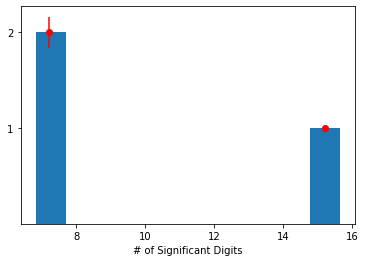

In [85]:
# python, tf, all
scores_mean = [15.65356, 6.833369, 6.832138]
scores_std = [2.366009e-15, 0.161014, 0.161623]

# plt.scatter(np.arange(3), scores_mean)
# plt.errorbar(np.arange(3), scores_mean, scores_std, linestyle='None', marker='^')

_, bins, bars = plt.hist(scores_mean, bins=10)
# plt.bar(scores_mean, np.arange(3))

# plt.bar(np.arange(3), scores_mean)
plt.errorbar([15.2,7.22], [1,2], yerr=[2.366009e-15, 0.161014], fmt="o", color="r")
plt.xlabel('# of Significant Digits'), plt.yticks([1,2]);

## Sanity Check Table

In [358]:
deepgo = [0.664, 0.695, 0.530, 9.591, 10.442, 44.370, 0.671, 0.738, 0.496]
ieee = [0.66395778471647093344, 0.69443807413568603426, 0.53016021292928316999, 9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873, 0.67070835431591591114, 0.73794627562522752129, 0.49586062981998213495]
tf = [0.66395778471647093344, 0.69443807413568603426, 0.53016021292928316999, 9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873, 0.67070835431591591114, 0.73794628705269516011, 0.49586067035813807813]
        
alll = [0.66395778471647093344, 0.69443807413568603426,0.53016021292928316999, 9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873, 0.67070835431591591114, 0.73794627562522752129, 0.49586066235736331320]
a = [deepgo, ieee, ieee, ieee, tf, alll]

In [383]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

header = pd.MultiIndex.from_product([['Fmax','Smin', 'AUPR'],
                                     ['MF','CC','BP']],
                                    names=['',''])
df = pd.DataFrame(a, 
                  index=['DeepGOPlus','IEEE','Fuzzy Python','Fuzzy Libmath','Verrou TF', 'Verrou All'], 
                  columns=header)
# df = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size','11pt')])])
# df.set_properties(**{'text-align': 'center','font-size':'11pt',"border-left": "1pt solid black"}) #.hide_index()

# with pd.option_context('display.precision', 9): display(df)

final = df.style
final.set_table_styles([
    # Selector 3
    {'selector': 'th', 'props': [
        ('text-align', 'center'),
        ('font-size', '10pt'),
        ('border-left', 'solid'),
#         ('border-width', '1px'),
        ('border-color', 'black')  # Missing Border Color here
    ]}
])
# final.set_properties(subset=['Fmax'], **{"border-right": "1pt solid black"})
# final.set_properties(subset=['Smin'], **{"border-right": "1pt solid black"})
# final.set_properties(subset=['AUPR'], **{"border-right": "1pt solid black"})


In [451]:
fmax_deepgo = [0.664, 0.695, 0.530]
smin_deepgo = [9.591, 10.442, 44.370] 
aupr_deepgo = [0.671, 0.738, 0.496]
fmax_ieee = [0.66395778471647093344, 0.69443807413568603426, 0.53016021292928316999] 
smin_ieee = [9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873]
aupr_ieee = [0.67070835431591591114, 0.73794627562522752129, 0.49586062981998213495]
fmax_tf = [0.66395778471647093344, 0.69443807413568603426, 0.53016021292928316999]
smin_tf = [9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873] 
aupr_tf = [0.67070835431591591114, 0.73794628705269516011, 0.49586067035813807813]
        
fmax_alll = [0.66395778471647093344, 0.69443807413568603426,0.53016021292928316999] 
smin_alll = [9.59723337994734038148, 10.44803272679657446531, 44.37791113877766235873] 
aupr_alll = [0.67070835431591591114, 0.73794627562522752129, 0.49586066235736331320]

a1 = [fmax_deepgo, fmax_ieee, fmax_ieee, fmax_ieee, fmax_tf, fmax_alll]
a2 = [smin_deepgo, smin_ieee, smin_ieee, smin_ieee, smin_tf, smin_alll]
a3 = [aupr_deepgo, aupr_ieee, aupr_ieee, aupr_ieee, aupr_tf, aupr_alll]

# header = pd.MultiIndex.from_product([['Fmax'],
#                                      ['MF','CC','BP']],
#                                     names=['',''])
df1 = pd.DataFrame(a1, 
                  index=['DeepGOPlus','IEEE','Fuzzy Python','Fuzzy Libmath','Verrou TF', 'Verrou All'], 
                  columns=['MF', 'CC', 'BP'])

df2 = pd.DataFrame(a2, 
                  index=['DeepGOPlus','IEEE','Fuzzy Python','Fuzzy Libmath','Verrou TF', 'Verrou All'], 
                  columns=['MF', 'CC', 'BP'])

# final = df1.style
# final.set_table_styles([
#     # Selector 3
#     {'selector': 'th', 'props': [
#         ('text-align', 'center'),
#         ('font-size', '10pt'),
#         ('border-right', 'solid'),
# #         ('border-width', '1px'),
#         ('border-color', 'black')  # Missing Border Color here
#     ]}
# ])
# result = pd.concat([df1, df4], axis=1, join="inner")

# df1.style\
# #      .set_properties(subset=['Fmax'], **{"border-right": "1pt solid black"})\
#      .apply(functools.partial(borderTop, "BP"), axis=1)


In [465]:
pd.concat([df1, df2], axis=1, join="inner")



,MF,CC,BP
DeepGOPlus,9.591000000,10.442000000,44.370000000
IEEE,9.597233380,10.448032727,44.377911139
Fuzzy Python,9.597233380,10.448032727,44.377911139
Fuzzy Libmath,9.597233380,10.448032727,44.377911139
Verrou TF,9.597233380,10.448032727,44.377911139
Verrou All,9.597233380,10.448032727,44.377911139


In [455]:
final = df1.style

final.set_caption("Fmax").set_table_styles([
#     # Selector 1
#     {'selector': '',
#      'props': [('border', '2px black solid !important')]},
#     # Selector 2
    {'selector': 'caption',
     'props': [
        ('text-align', 'center'),
         ('color', 'black'),
         ('font-size', '25px'),
         ('text-align', 'center'),
         ('border', '3px black solid !important')]},
    # Selector 3
    {'selector': 'th', 'props': [
        ('text-align', 'center')
#         ('font-size', '10pt'),
#         ('border-style', 'solid'),
#         ('border-width', '1px'),
#         ('border-color', 'black')  # Missing Border Color here
    ]}
])

final2 = df2.style

final2.set_caption("Smin").set_table_styles([
#     # Selector 1
#     {'selector': '',
#      'props': [('border', '2px black solid !important')]},
#     # Selector 2
    {'selector': 'caption',
     'props': [
        ('text-align', 'center'),
         ('color', 'black'),
         ('font-size', '25px'),
         ('text-align', 'center'),
         ('border', '3px black solid !important')]},
    # Selector 3
    {'selector': 'th', 'props': [
        ('text-align', 'center')
#         ('font-size', '10pt'),
#         ('border-style', 'solid'),
#         ('border-width', '1px'),
#         ('border-color', 'black')  # Missing Border Color here
    ]}
])

,MF,CC,BP
DeepGOPlus,9.591000000,10.442000000,44.370000000
IEEE,9.597233380,10.448032727,44.377911139
Fuzzy Python,9.597233380,10.448032727,44.377911139
Fuzzy Libmath,9.597233380,10.448032727,44.377911139
Verrou TF,9.597233380,10.448032727,44.377911139
Verrou All,9.597233380,10.448032727,44.377911139


In [365]:
df.style\
     .set_properties(subset=['Fmax'], **{'font-weight': 'bold', "border-left": "1pt solid black"})


AttributeError: 'Styler' object has no attribute 'style'

In [413]:
import pandas as pd
import numpy as np
from IPython.display import HTML
import functools

def borderTop(strRow, srRow):
    print(strRow, type(srRow), srRow.name)
    
    if srRow.name == strRow:
        return [ "border-right: 1pt solid black; font-weight: bold" for sCol in srRow ]
    else:
        return [""] * len(srRow)

# np.random.seed(0)  # to make the numbers reproducible
# dfBody = pd.DataFrame(np.random.randint(0,10,(5,3)))

# make a column of row totals and append it on the right
# srRowTots = dfBody.sum(axis=1).astype(int)
# srRowTots.name="Total"
# dfBody2 = pd.concat([dfBody, srRowTots], axis=1)

# make a row of column totals and append to the bottom
# srColTots = dfBody2.sum().astype(int)
# srColTots.name="Total"
# dfBodyTots = pd.concat([dfBody2, srColTots.to_frame().T])

# Display it, making the total column and row bold and bordered
# df.style\
#      .set_properties(subset=['Total'], **{'font-weight': 'bold', "border-left": "1pt solid black"})\
#      .apply(functools.partial(borderTop, "Total"), axis=1)

In [372]:
final = df.style
final.set_table_styles([
    # Selector 3
    {'selector': 'th', 'props': [
        ('font-size', '10pt'),
        ('border-style', 'solid'),
#         ('border-width', '1px'),
        ('border-color', 'black')  # Missing Border Color here
    ]}
])

## Metric Tables

In [30]:
pd.set_option('display.float_format', '{:.20f}'.format)
# df_mf = pd.read_pickle('/home/ines/Documents/Thesis/Fuzzy Libmath/fuzzy_libmath_bp.pkl')
df_mf = pd.read_pickle('/home/ines/Documents/Thesis/Verrou_tf/verrou_all_bp.pkl')

In [31]:
df_mf.loc['AUPR']

Original Result                    0.49586062981998213495
Standard Deviation                 0.00000003683109367506
Mean                               0.49586066235736331320
Standard Error                     0.00000001164701447282
[General] Absolute  significant:        7.224719895935547
[General] Absolute contributing:        7.224719895935547
Name: AUPR, dtype: object

In [218]:
[0.6639577847164709, 0.0, 15.65355977452702, 9.59723337994734, 0.0, 15.65355977452702, 0.6707083543159159, 0.0, 15.65355977452702]


0.6707083543159159

#### Fuzzy Libmath

In [313]:
mf = [0.66395778471647093344, 0.0, 15.65355977452702, 9.59723337994734038148, 0.0, 15.65355977452702, 0.67070835431591591114, 0.0, 15.65355977452702]
        
cc = [0.69443807413568603426, 0.0, 15.65355977452702, 10.44803272679657446531, 0.0, 15.65355977452702, 0.73794627562522752129, 0.0, 15.65355977452702]

bp = [0.53016021292928316999, 0.0, 15.65355977452702, 44.37791113877766235873, 0.0, 15.65355977452702, 0.49586062981998213495, 0.0, 15.65355977452702]
a = [mf, cc, bp]

header = pd.MultiIndex.from_product([['Fmax','Smin', 'AUPR'],
                                     ['Mean','Standard Deviation','Significant Digits']],
                                    names=['',''])
df = pd.DataFrame(a, 
                  index=['MF','CC','BP'], 
                  columns=header)
df = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size','11pt')])])
df.set_properties(**{'text-align': 'center','font-size':'11pt'}) #.hide_index()

df


#### Fuzzy Python

In [294]:
mf = [0.66395778471647093344, 0.0, 15.65355977452702, 9.59723337994734038148, 0.0, 15.65355977452702, 0.67070835431591591114, 0.0, 15.65355977452702]
        
cc = [0.69443807413568603426, 0.0, 15.65355977452702, 10.44803272679657446531, 0.0, 15.65355977452702, 0.73794627562522752129, 0.0, 15.65355977452702]

bp = [0.53016021292928316999, 0.0, 15.65355977452702, 44.37791113877766235873, 0.0, 15.65355977452702, 0.49586062981998213495, 0.0, 15.65355977452702]
a = [mf, cc, bp]

header = pd.MultiIndex.from_product([['Fmax','Smin', 'AUPR'],
                                     ['Mean','Standard Deviation','Significant Digits']],
                                    names=['',''])
df = pd.DataFrame(a, 
                  index=['MF','CC','BP'], 
                  columns=header)
df = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size','11pt')])])
df.set_properties(**{'text-align': 'center','font-size':'11pt'}) #.hide_index()

df

#### Verrou All

In [242]:
mf = [0.66395778471647093344, 0.0, 15.65355977452702, 9.59723337994734038148, 0.0, 15.65355977452702, 0.67070835431591591114, 0.0, 15.65355977452702]
        
cc = [0.69443807413568603426, 0.0, 15.65355977452702, 10.44803272679657446531, 0.0, 15.65355977452702, 0.73794627562522752129, 0.0, 7.224719895935547]

bp = [0.53016021292928316999, 0.0, 15.65355977452702, 44.37791113877766235873, 0.0, 15.65355977452702, 0.49586066235736331320, 3.6831093675057546e-08, 7.224719895935547]

a = [mf, cc, bp]

header = pd.MultiIndex.from_product([['Fmax','Smin', 'AUPR'],
                                     ['Mean','Standard Deviation','Significant Digits']],
                                    names=['',''])
df = pd.DataFrame(a, 
                  index=['MF','CC','BP'], 
                  columns=header)
df = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size','11pt')])])
df.set_properties(**{'text-align': 'center','font-size':'11pt'}) #.hide_index()

df

#### Verrou TF

In [219]:
mf = [0.6639577847164709, 0.0, 15.65355977452702, 9.59723337994734, 0.0, 15.65355977452702, 0.6707083543159159, 0.0, 15.65355977452702]
        
cc = [0.694438074135686, 0.0, 15.65355977452702, 10.448032726796574, 0.0, 15.65355977452702, 0.7379462870526952, 3.6136825626552926e-08, 7.224719895935547]

bp = [0.5301602129292832, 0.0, 15.65355977452702, 44.37791113877766, 0.0, 15.65355977452702, 0.4958606703581381, 3.3860006444454065e-08, 7.224719895935547]

a = [mf, cc, bp]
pd.set_option("display.precision",9)
pd.set_option('display.float_format', '{:.2E}'.format)

header = pd.MultiIndex.from_product([['Fmax','Smin', 'AUPR'],
                                     ['Mean','Standard Deviation','Significant Digits']],
                                    names=['',''])
df = pd.DataFrame(a, 
                  index=['MF','CC','BP'], 
                  columns=header)
df = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center'), ('font-size','11pt')])])
df.set_properties(**{'text-align': 'center','font-size':'11pt'}) #.hide_index()

# with pd.option_context('display.precision', 3): display(df)
df

\begin{table}[h!]
\resizebox{\textwidth}{!}{%
\begin{tabularx}{cc|lll|lll|lll|}
\cline{3-11}
\multicolumn{1}{l}{} & \textbf{} & \multicolumn{3}{c|}{\textbf{Fmax}} & \multicolumn{3}{c|}{\textbf{Smin}} & \multicolumn{3}{c|}{\textbf{AUPR}} \\ \cline{3-11} 
 & \textbf{} & \multicolumn{1}{c|}{\textbf{Mean}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Standard\\ Deviation\end{tabular}}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Significant\\ Digits\end{tabular}}} & \multicolumn{1}{c|}{\textbf{Mean}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Standard\\ Deviation\end{tabular}}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Significant\\ Digits\end{tabular}}} & \multicolumn{1}{c|}{\textbf{Mean}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Standard\\ Deviation\end{tabular}}} & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Significant\\ Digits\end{tabular}}} \\ \hline
\multicolumn{1}{|c|}{\multirow{3}{*}{\textbf{\begin{tabular}[c]{@{}c@{}}Fuzzy\\ Python\end{tabular}}}} & \textbf{mf} & \multicolumn{1}{l|}{0.663957785} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{9.597233380} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.670708354} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{cc} & \multicolumn{1}{l|}{0.694438074} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{10.448032727} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.737946276} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{bp} & \multicolumn{1}{l|}{0.530160213} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{44.377911139} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.495860630} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \hline                          
\multicolumn{1}{|c|}{\multirow{3}{*}{\textbf{\begin{tabular}[c]{@{}c@{}}Fuzzy \\ Libmath\end{tabular}}}} & \textbf{mf} & \multicolumn{1}{l|}{0.663957785} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{9.597233380} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.670708354} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{cc} & \multicolumn{1}{l|}{0.694438074} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{10.448032727} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.737946276} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{bp} & \multicolumn{1}{l|}{0.530160213} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{44.377911139} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.495860630} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \hline

\multicolumn{1}{|c|}{\multirow{3}{*}{\textbf{\begin{tabular}[c]{@{}c@{}}Verrou\\ TF\end{tabular}}}} & \textbf{mf} & \multicolumn{1}{l|}{0.663957785} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{9.597233380} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.670708354} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{cc} & \multicolumn{1}{l|}{0.694438074} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{10.448032727} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.737946287} & \multicolumn{1}{l|}{0.000000036} & 7.224719896 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{bp} & \multicolumn{1}{l|}{0.530160213} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{44.377911139} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.495860670} & \multicolumn{1}{l|}{0.000000034} & 7.224719896 \\ \hline                        

\multicolumn{1}{|c|}{\multirow{3}{*}{\textbf{\begin{tabular}[c]{@{}c@{}}Verrou\\ All\end{tabular}}}} & \textbf{mf} & \multicolumn{1}{l|}{0.663957785} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{9.597233380} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.670708354} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{cc} & \multicolumn{1}{l|}{0.694438074} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{10.448032727} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.737946276} & \multicolumn{1}{l|}{0.000000000} & 7.224719896 \\ \cline{2-11} 
\multicolumn{1}{|c|}{} & \textbf{bp} & \multicolumn{1}{l|}{0.530160213} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{44.377911139} & \multicolumn{1}{l|}{0.000000000} & 15.653559775 & \multicolumn{1}{l|}{0.495860662} & \multicolumn{1}{l|}{0.000000037} & 7.224719896 \\ \hline
\end{tabularx}}
\end{table}